In [1]:
import sys
from os import listdir
from os.path import isdir, isfile, join
import os.path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from time import time

## Sammeln von CSV Dateien innerhalb eines Verzeichnisses

In [2]:
def gatherCSVFilePathsfromDirectory(dir):
    print(dir)
    filepaths = []
    for f in listdir(dir):
        path = join(dir, f)
        if isfile(path) and f.endswith(".csv"):
            filepaths.append(path)

    if len(filepaths) == 0:
        exit("Directory does not contain any csv files: %s" % dir)

    filepaths = np.sort(filepaths)
    print("Found %s files." % len(filepaths))

    return filepaths


## Einlesen der CSV Dateien aus den verschiedenen Verzeichnissen in eine Map von Listen von Dataframes

In [3]:
SOURCE_DIR = "./data/"


SOURCE_DIR = os.path.abspath(SOURCE_DIR)
if not isdir(SOURCE_DIR):
    exit("That's not a directory!")
else:
    print(SOURCE_DIR)

elems = listdir(SOURCE_DIR)
print(elems)
directories = {}
for e in elems:
    path = join(SOURCE_DIR, e)
    
    if isdir(path):
        filepaths = gatherCSVFilePathsfromDirectory(path)

        directories[e] = []
        for filepath in filepaths:
            dataframe = pd.read_csv(filepath, header=1)
            dataframe.columns = dataframe.columns.str.strip().str.replace('(', '').str.replace(')', '') 
            
            # convert ms timestamp to ids
            dataframe = dataframe.assign(id= lambda x: dataframe.index )
            dataframe = dataframe.drop(columns=['ms'])
            
            if 'mA' in dataframe:
                dataframe = dataframe.assign(A= lambda x: x.mA / 1000.0).drop(columns=['mA'])
            directories[e].append(dataframe)
            

/home/felix/DataScienceProjekt/data
['ohp_halb-single.psdata', 'lampe-single', 'laptop-single', 'ohp_voll-laptop-bosch-lampe.psdata', 'ohp_halb-laptop', 'lampe-ohp_voll', 'ohp_voll-laptop', 'ohp_voll-single.psdata', 'ohp_halb-laptop.psdata', 'bosch-single', 'ohp_halb-laptop-lampe', 'ohp_halb-laptop-lampe.psdata', 'ohp_voll-laptop-bosch-lampe', 'lampe-ohp_voll.psdata', 'ohp_halb-single', 'ohp_voll-single']
/home/felix/DataScienceProjekt/data/lampe-single
Found 256 files.
/home/felix/DataScienceProjekt/data/laptop-single
Found 256 files.
/home/felix/DataScienceProjekt/data/ohp_halb-laptop
Found 256 files.
/home/felix/DataScienceProjekt/data/lampe-ohp_voll
Found 256 files.
/home/felix/DataScienceProjekt/data/ohp_voll-laptop
Found 256 files.
/home/felix/DataScienceProjekt/data/bosch-single
Found 256 files.
/home/felix/DataScienceProjekt/data/ohp_halb-laptop-lampe
Found 256 files.
/home/felix/DataScienceProjekt/data/ohp_voll-laptop-bosch-lampe
Found 256 files.
/home/felix/DataScienceProjekt

# Beschaffenheit der Daten (Auszug)

In [4]:
dfs = directories['bosch-single']
print("Amount of files:", len(dfs), "\n")
print("head:\n", dfs[0].head(10), "\n")
print("stats:\n", dfs[0].describe(), "\n")

Amount of files: 256 

head:
           V         A  id
0 -8.224738 -0.290353   0
1 -8.224738 -0.281320   1
2 -3.753777 -0.281320   2
3  0.732444 -0.290353   3
4  0.732444 -0.281320   4
5  0.732444 -0.281320   5
6  5.218665 -0.272256   6
7  5.218665 -0.290353   7
8  9.689627 -0.281320   8
9  9.689627 -0.281320   9 

stats:
                  V            A           id
count  2445.000000  2445.000000  2445.000000
mean     38.762161     0.065086  1222.000000
std     222.765937     0.424451   705.955027
min    -321.848200    -0.371715     0.000000
25%    -178.472200    -0.317454   611.000000
50%      81.362350    -0.100528  1222.000000
75%     251.609800     0.450881  1833.000000
max     314.340600     0.884793  2444.000000 



## Was wir gemacht haben

- Zeit diskretisieren 0ms = 0 und 20ms = 2445 (neue spalte -> id des datensatzes) done
- mA zu A umrechnen (falls vorhanden) done
- geht multilabel mit gradient boosting? jaein, vielleicht
- in X und Y aufteilen 
- attacke!


## Zusammenfassen der einzelnen Dataframes zu einem geräteübergreifenden DF

In [5]:
features = []

for label, data in directories.items():
    # pro gerät alle daten in einen dataframe
    res = pd.concat(data, sort=False)
    #zu der tabelle eine spalte mit label hinzufügen
    res = res.assign(labels= lambda x: label)
    #_ = plt.scatter(res['V'], res['A'])
    #_ = plt.xlabel("Volt")
    #_ = plt.ylabel("Ampere")
    #print("Showing: " + label)
    #plt.show()
    features.append(res)
    
features = pd.concat(features, sort=True)

## Erstellen der X und Y Datensätze

In [ ]:
X = features.drop(columns=['labels'])

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
Y = features['labels']

Y = pd.get_dummies(Y)

mapFromIdToLabel = Y.assign(labels= lambda x:  x['bosch-single'] * 0 + x['lampe-ohp_voll'] * 1 + x['lampe-single'] * 2 + x['laptop-single'] * 3 + x['ohp_halb-laptop']* 4 + x['ohp_halb-laptop-lampe'] * 5 + x['ohp_halb-single'] * 6 + x['ohp_voll-laptop'] * 7 + x['ohp_voll-laptop-bosch-lampe'] * 8 + x['ohp_voll-single'] * 9)

Y = mapFromIdToLabel['labels']

## Scatterplot um eventuelle Zusammenhänge zu erkennen

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2c0b68780>,
      dtype=object)

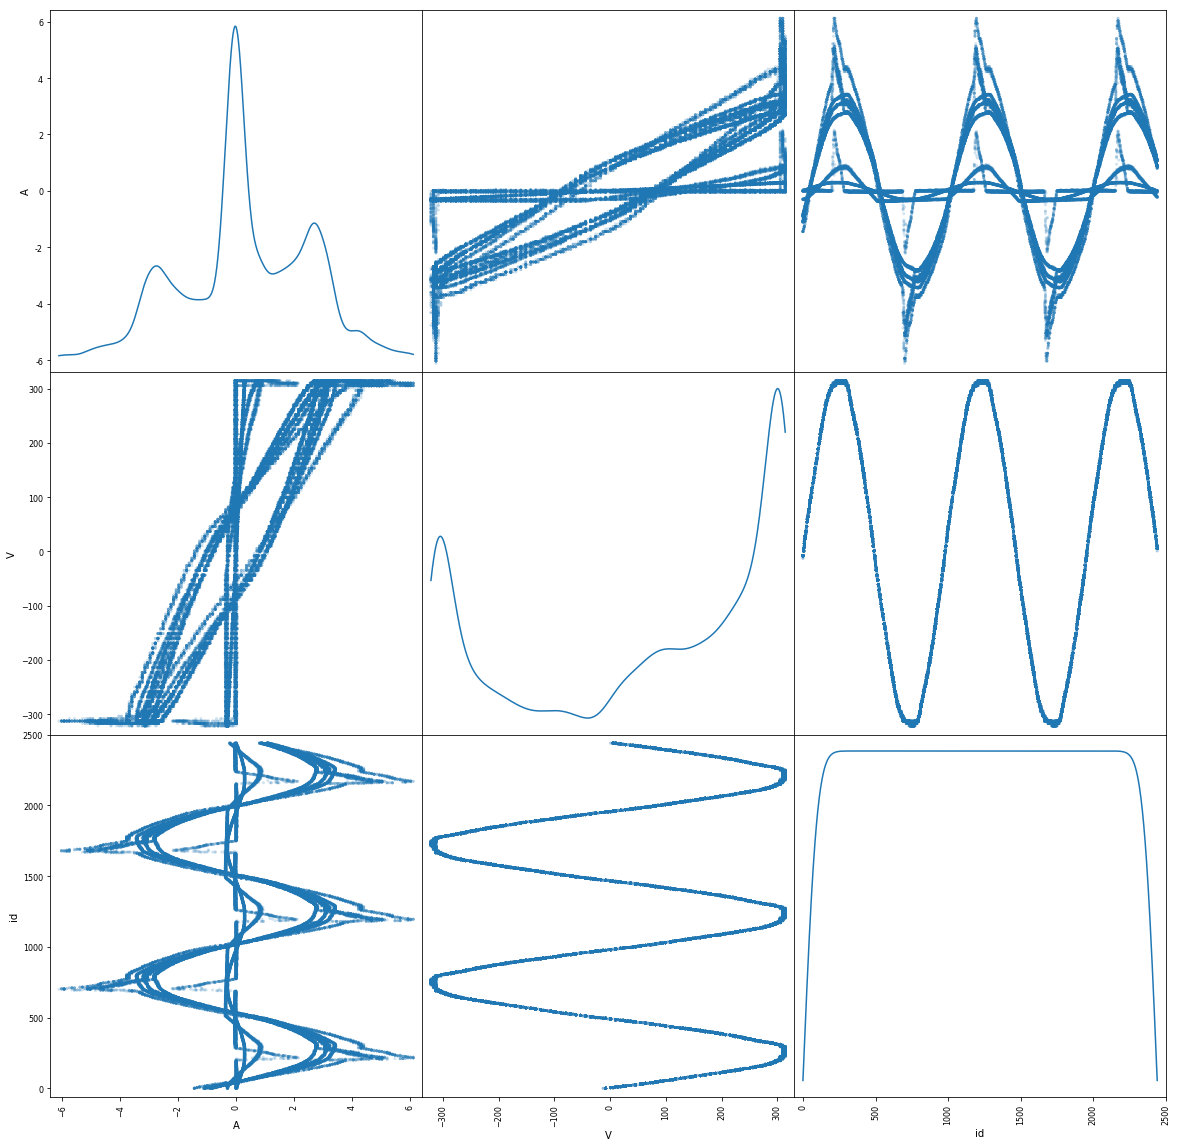

In [6]:
%matplotlib inline
from pandas.plotting import scatter_matrix
scatter_matrix(features[0::100], alpha=0.2, figsize=(20, 20), diagonal='kde')

## Splitten der Daten und Training

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

clf = RandomForestClassifier(n_estimators=16, random_state=42, min_samples_split=2, verbose=2, n_jobs=-1)
startTime = time()

clf.fit(X_train, Y_train)

endTime = time()
diff = (endTime - startTime)
print("Time taken:", diff)

building tree 1 of 16
building tree 2 of 16
building tree 3 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   53.2s remaining:   31.9s


Time taken: 57.54824757575989


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   57.1s finished


In [21]:
print("Train:", round(10000*clf.score(X_train, Y_train))/100.0)
print("Test:", round(10000*clf.score(X_test, Y_test))/100.0)

[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    5.1s remaining:    3.1s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    6.1s finished


Train: 90.65


[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    1.2s remaining:    0.7s


Test: 90.4


[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    1.5s finished


## Vorhersage eines willkürlich herausgegriffenen Samples

In [10]:
num_test_samples = len(X_test)
sample = np.random.randint(len(X_test))

print("evaluating sample", sample, "of", num_test_samples)
#print(Y_test.head(), type(Y_test))
sample_X = X_test[sample]
sample_Y = Y_test[sample:sample+1]

print(sample_X)
print(sample_Y)

clf.predict(sample_X.reshape(1, -1))

[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


evaluating sample 862468 of 1251840
[0.49777532 0.02818283 0.72831424]
1780    3
Name: labels, dtype: uint8


array([3], dtype=uint8)

# Modell mit neuen Daten evaluieren und plotten

- Daten aufzeichnen
- Als CSV exportieren
- CSV einlesen
- Für jeden Strom- und Spannungsverlauf in einer Datei (50ms Zeitfenster)
    - Aktives Gerät vorhersagen
    - Ergebnis ist Modus der Vorhersagen

## Einlesen der neuen Daten

In [22]:
filepaths = gatherCSVFilePathsfromDirectory("./data/ohp_voll-laptop-bosch-lampe/")
dataframes = []

for filepath in filepaths:
    dataframe = pd.read_csv(filepath, header=1)
    dataframe.columns = dataframe.columns.str.strip().str.replace('(', '').str.replace(')', '') 

    # convert ms timestamp to ids
    dataframe = dataframe.assign(id= lambda x: dataframe.index )
    dataframe = dataframe.drop(columns=['ms'])

    if 'mA' in dataframe:
        dataframe = dataframe.assign(A= lambda x: x.mA / 1000.0).drop(columns=['mA'])
    
    dataframes.append(dataframe)
    

./data/ohp_voll-laptop-bosch-lampe/
Found 256 files.


## Welches Gerät wurde am häufigsten innerhalb der 50ms vorhergesagt?

In [23]:
from scipy import stats
clf.set_params(verbose=0)

wave_predictions = []
wave_probabilities = []

for wave in dataframes:
    wave = wave.sort_index(axis=1)
    wave = min_max_scaler.transform(wave)
    # predict per sample
    predictions = clf.predict(wave)
    
    mode = stats.mode(predictions, axis=None)
    wave_predictions.append(mode[0][0])
    wave_probabilities.append(mode[1][0] * 100.0 / len(wave))

## Plotten der Genauigkeit

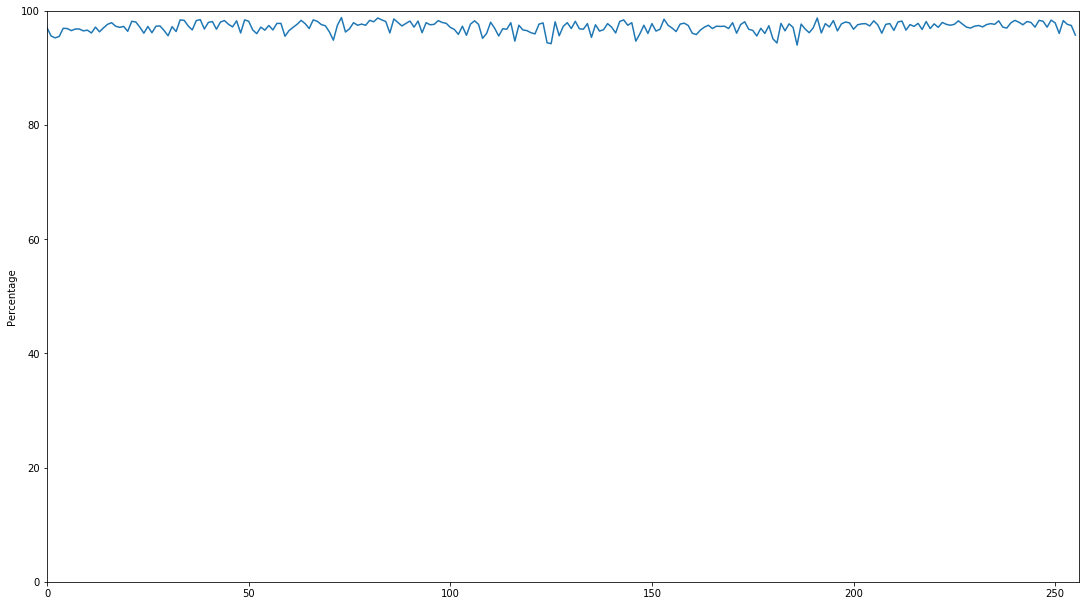

In [24]:
plt.plot(wave_probabilities)
plt.ylabel('Percentage')

axes = plt.gca()
axes.set_ylim([0,100])
axes.set_xlim([0,len(wave_probabilities)])
plt.gcf().set_size_inches(18.5, 10.5)

plt.show()

## Wann war welches Gerät aktiv?

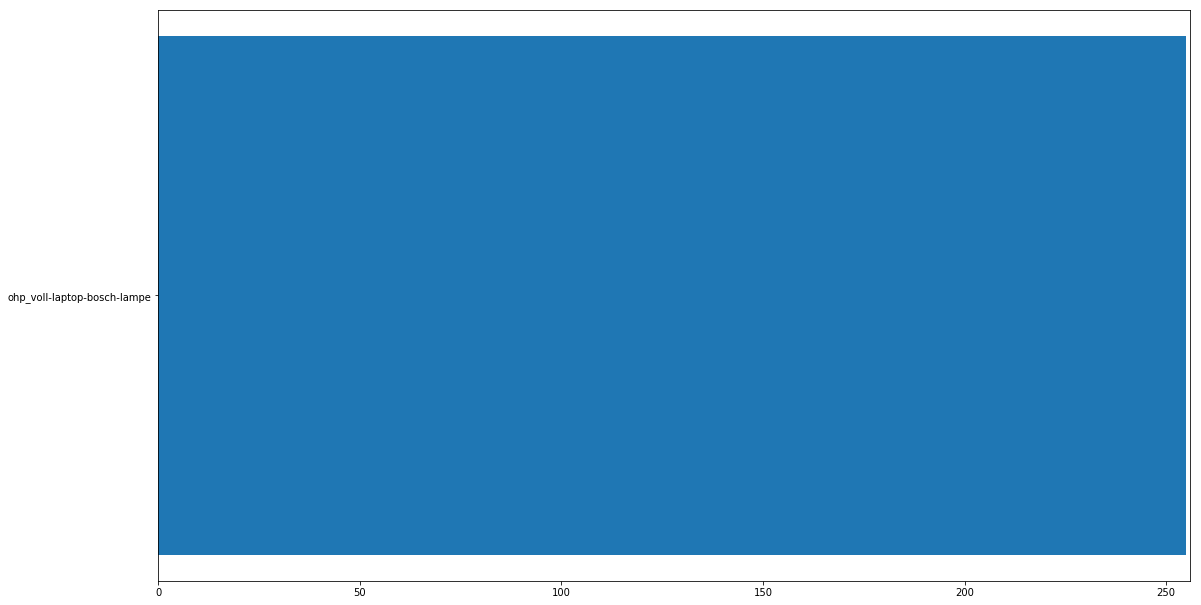

In [26]:
labels = mapFromIdToLabel.columns.values

begin = []
end =   []
event = []

last_label = -1
for (index, prediction) in enumerate(wave_predictions):
    
    if prediction != last_label:
        if last_label != -1:
            end.append(index)
        
        begin.append(index)
        event.append(labels[prediction])
        last_label = prediction

end.append(len(wave_predictions) - 1)
             
begin = np.array(begin)
end = np.array(end)

plt.barh(range(len(begin)),  end-begin, left=begin)
axes = plt.gca()
axes.set_xlim([0,len(wave_predictions)])
plt.gcf().set_size_inches(18.5, 10.5)

plt.yticks(range(len(begin)), event)
plt.show()

## Speichern des Modells

In [ ]:
joblib.dump(clf, 'trainedModelforFelixandDatascienceProject_longFilenamecausewerecool.pkl') 